In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


cpu


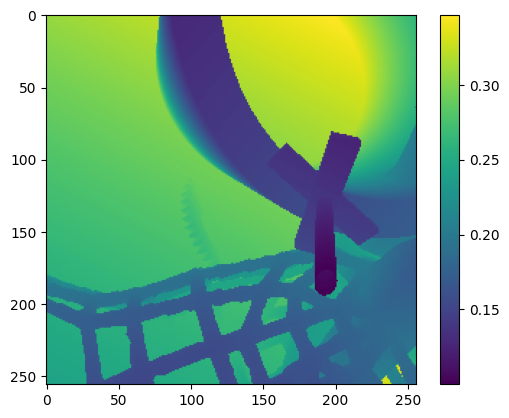

256 256
float16 float32
adaptive kernel size set to 11


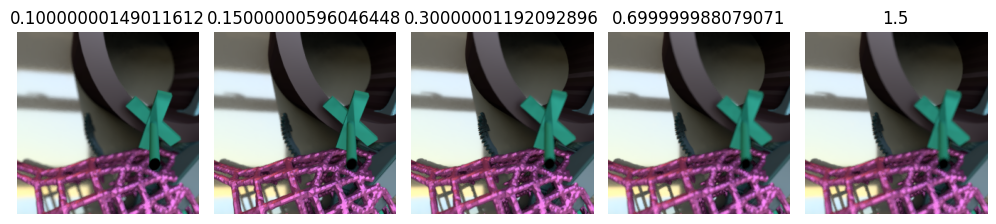

In [2]:
globals.init_DefocusNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
gt_dpt, defocus_stack = utils.load_single_sample_DefocusNet()
defocus_stack *= IMAGE_RANGE 

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape
print(width, height)
print(gt_dpt.dtype, defocus_stack.dtype)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)


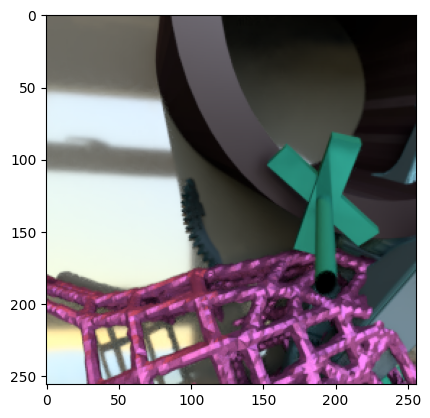

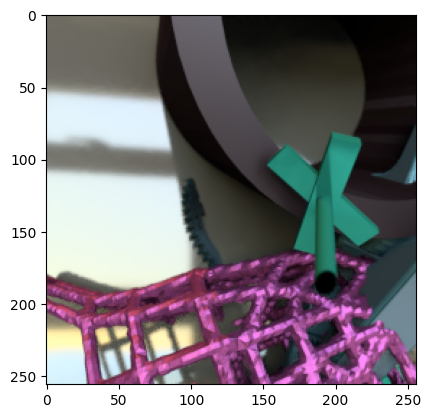

In [3]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

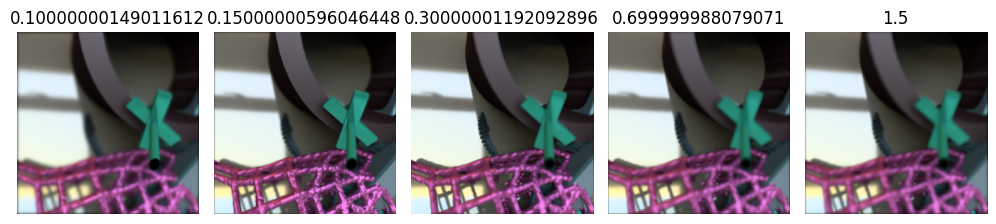

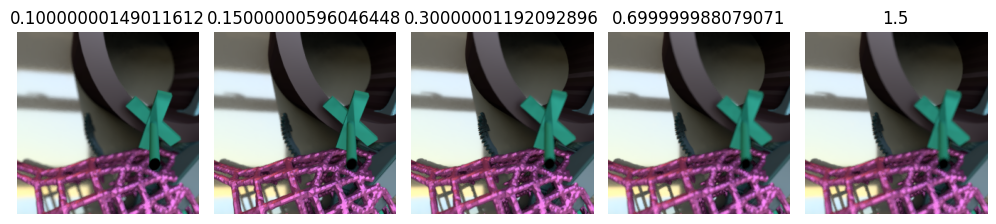

0 --> 2.3658203982590553e-05


In [4]:
# sanity check 

globals.thresh = 0
test_defocus_stack_none = forward_model.forward(gt_dpt, aif_init)
# globals.thresh = 0.5
# test_defocus_stack_05 = forward_model.forward(gt_dpt, aif_init)
# globals.thresh = 1
# test_defocus_stack_1 = forward_model.forward(gt_dpt, aif_init)
# globals.thresh = 2
# test_defocus_stack_2 = forward_model.forward(gt_dpt, aif_init)

utils.plot_single_stack(test_defocus_stack_none / IMAGE_RANGE, globals.Df)
# utils.plot_single_stack(test_defocus_stack_05 / IMAGE_RANGE, globals.Df)
# utils.plot_single_stack(test_defocus_stack_1 / IMAGE_RANGE, globals.Df)
# utils.plot_single_stack(test_defocus_stack_2 / IMAGE_RANGE, globals.Df)
utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

print('0 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_none / IMAGE_RANGE)**2)
# print('0.5 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_05 / IMAGE_RANGE)**2)
# print('1 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_1 / IMAGE_RANGE)**2)
# print('2 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_2 / IMAGE_RANGE)**2)


Created experiment folder: /data/holly_jackson/experiments/defocus-net-000373_2025-10-23_18-08-15
Images in range [0-255]


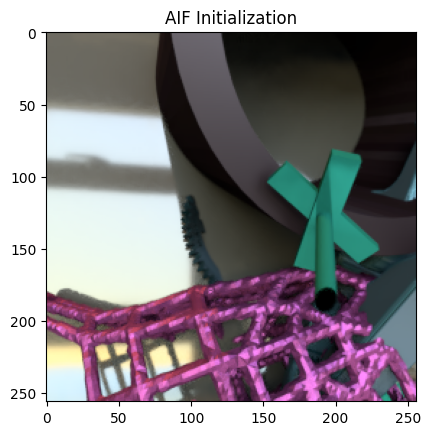

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [00:13<00:00,  7.35it/s]


GRID SEARCH DURATION 13.74264645576477


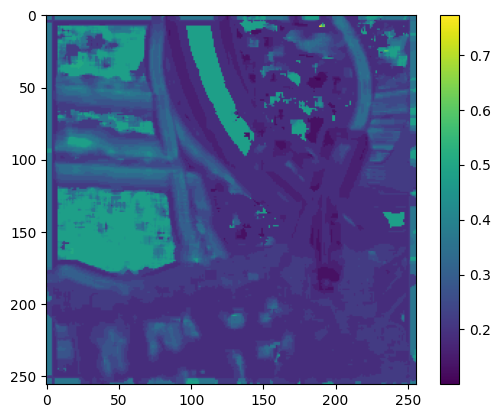


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 8.86652421951294


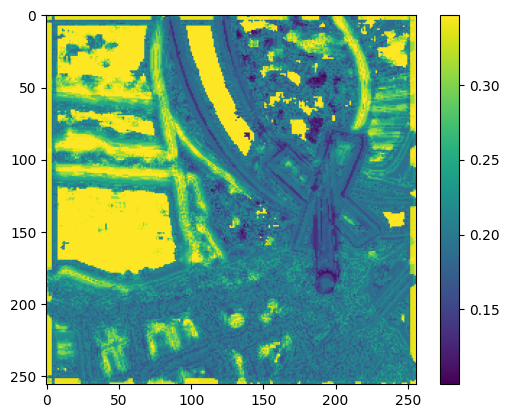

Loss: 60.79915 , TV: 2877.8723

DPT result range: [ 0.10345756 , 0.79875654 ]


Bounded FISTA...


Optimizing: 100%|█████████████████████████████| 200/200 [01:24<00:00,  2.37it/s]


r1norm 6247.7393 norm(x) 57594.766
FISTA duration 88.1776123046875

AIF result range: [ 0.0 , 255.0 ]
Loss: 39.709038 , TV: 3339393.5


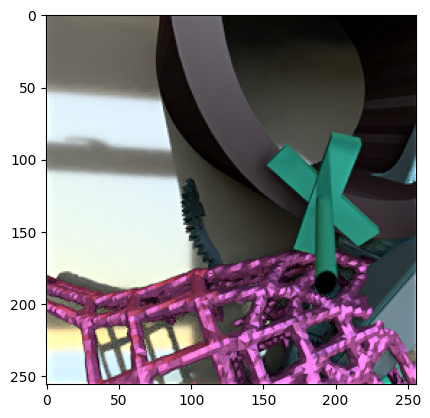

FULL ITER DURATION 113.23728942871094
ls_maxiter updated to 210


--------------------------



In [5]:
# -------------------
# COORDINATE DESCENT
# -------------------

globals.thresh = 0.5

dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=True, save_plots=False,
        experiment_name = 'defocus-net-000373', num_epochs = 1,
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        k = 1, aif_method = 'fista',
        finite_differences = False, num_Z = 100, 
        ls_maxiter = 200, ls_maxiter_multiplier = 1.05, 
        min_Z = 0.1, max_Z = 3,
        vmin = gt_dpt.min(), vmax = gt_dpt.max(), verbose = True)


RMS 0.100948736
Rel 0.3207432
{'delta1': 0.4880218505859375, 'delta2': 0.8033599853515625, 'delta3': 0.94647216796875}


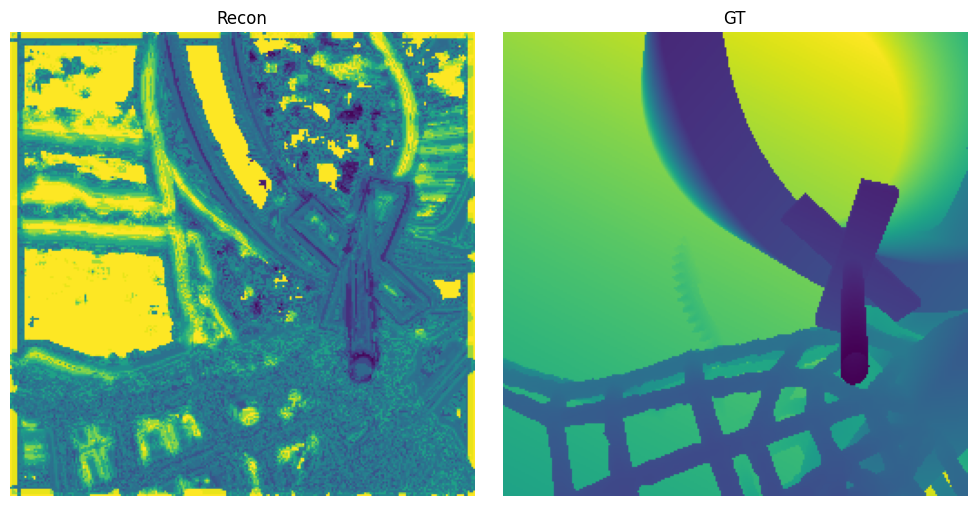

In [7]:
print('RMS', utils.compute_RMS(dpt, gt_dpt))
print('Rel', utils.compute_Rel(dpt, gt_dpt))
print(utils.compute_accuracy_metrics(dpt, gt_dpt))

utils.plot_compare_greyscale(dpt, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())


# todo: fista check if A @ x is quicker stacked or in loop

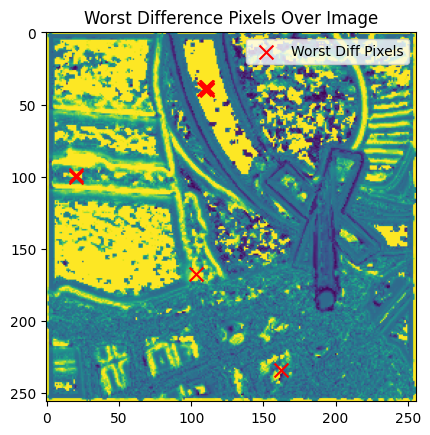

In [7]:
worst_coords = utils.get_worst_diff_pixels(dpt, gt_dpt, num_worst_pixels=10, vmin=gt_dpt.min(), vmax=gt_dpt.max())

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - gt_dpt)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [8]:
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = 0.1, max_Z = 3, num_Z = 100, k = 1)

print(k_min_indices.shape)

Grid search         : 100%|███████████████████| 100/100 [00:13<00:00,  7.62it/s]


(256, 256, 1)


3 0.18787879 0.012742341 0.0016568452
5 0.24646464 -0.0032536685 -0.0058201253
13 0.48080808 0.00013151765 -0.0020120665
14 0.510101 -0.0020120665 -0.0021993294


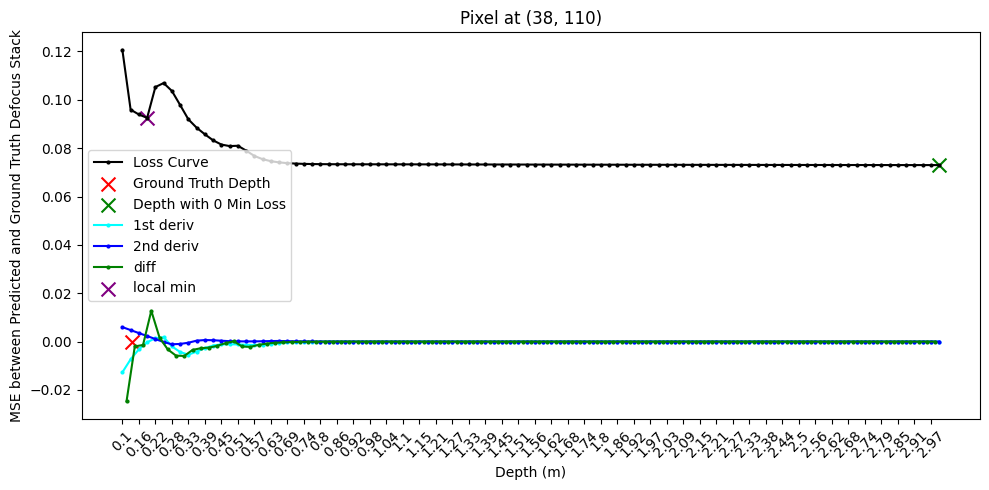

3 0.18787879 0.011237077 0.0017512068
5 0.24646464 -0.0032719225 -0.0057805628
13 0.48080808 0.0001443103 -0.001650855
14 0.510101 -0.001650855 -0.0017143935
21 0.7151515 3.771484e-05 6.003678e-05
59 1.8282828 -2.9802322e-08 8.493662e-07
60 1.8575758 8.493662e-07 -1.1324883e-06
61 1.8868687 -1.1324883e-06 2.5331974e-07
62 1.9161617 2.5331974e-07 -3.5762787e-07
63 1.9454546 -3.5762787e-07 -2.8312206e-07
69 2.121212 4.8428774e-07 -1.0207295e-06
70 2.150505 -1.0207295e-06 -5.9604645e-07


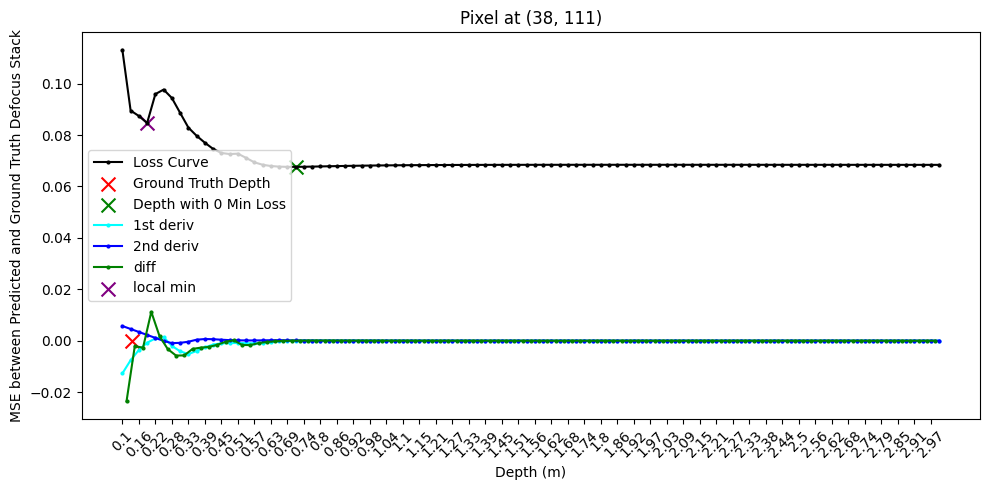

3 0.18787879 0.007016208 0.0011529848
5 0.24646464 -0.00230214 -0.004024513
13 0.48080808 6.262213e-05 -0.0010172129
14 0.510101 -0.0010172129 -0.0010306723
20 0.6858586 1.0322779e-05 3.2037497e-05
44 1.3888888 -4.5448542e-07 4.0978193e-07
45 1.4181818 4.0978193e-07 -7.748604e-07
46 1.4474747 -7.748604e-07 -9.685755e-07


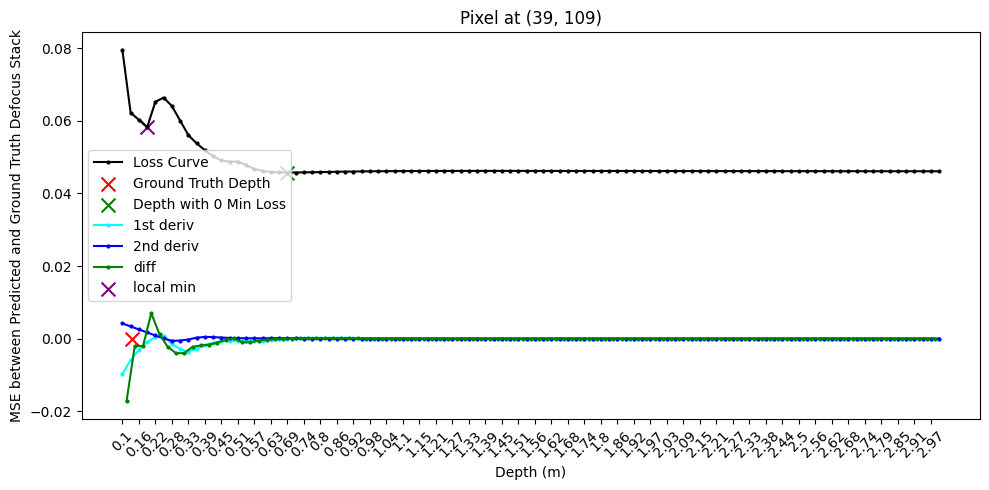

2 0.15858586 0.0009884462 0.01314985
5 0.24646464 -0.002517365 -0.0044496283
13 0.48080808 4.1477382e-05 -0.0019333363
14 0.510101 -0.0019333363 -0.002198875


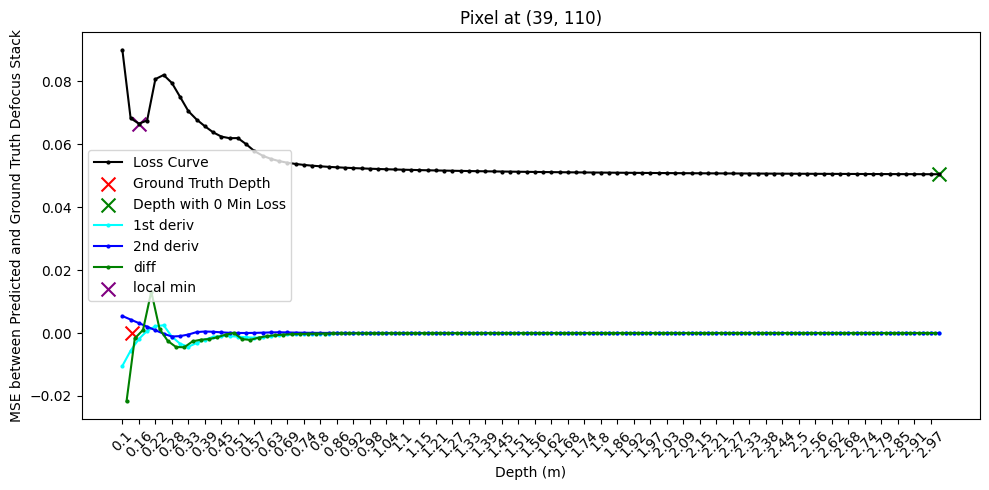

3 0.18787879 0.011880562 0.0015323982
5 0.24646464 -0.0026194602 -0.004749559
13 0.48080808 2.4043024e-05 -0.0017349273
14 0.510101 -0.0017349273 -0.0018859617


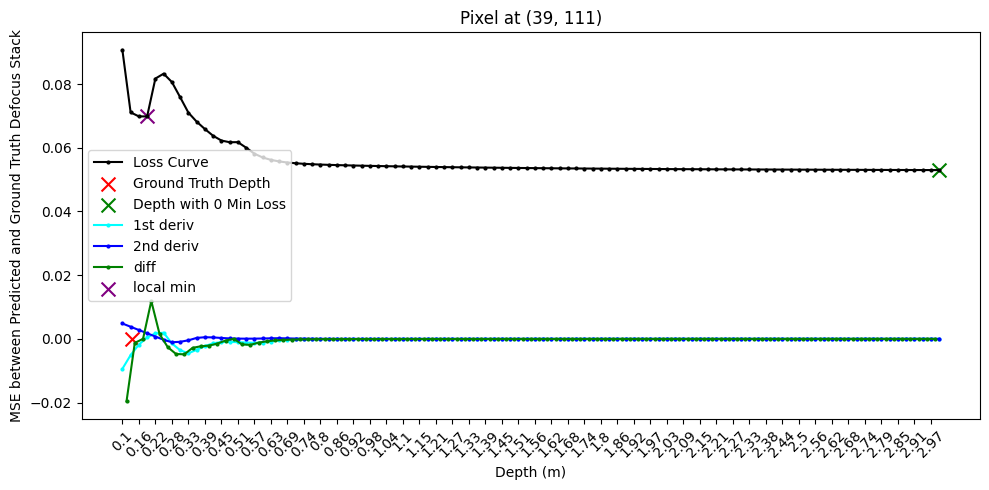

3 0.18787879 0.010589331 0.0008380711
5 0.24646464 -0.0032279342 -0.005187407
13 0.48080808 0.00010456145 -0.0016435385
14 0.510101 -0.0016435385 -0.0017945021
28 0.920202 1.989305e-06 1.7806888e-06
30 0.9787879 -2.2351742e-07 3.1888485e-06
31 1.0080808 3.1888485e-06 9.23872e-07
38 1.2131313 -2.6077032e-07 -9.909272e-07
69 2.121212 2.9802322e-08 -1.5571713e-06
70 2.150505 -1.5571713e-06 -2.540648e-06


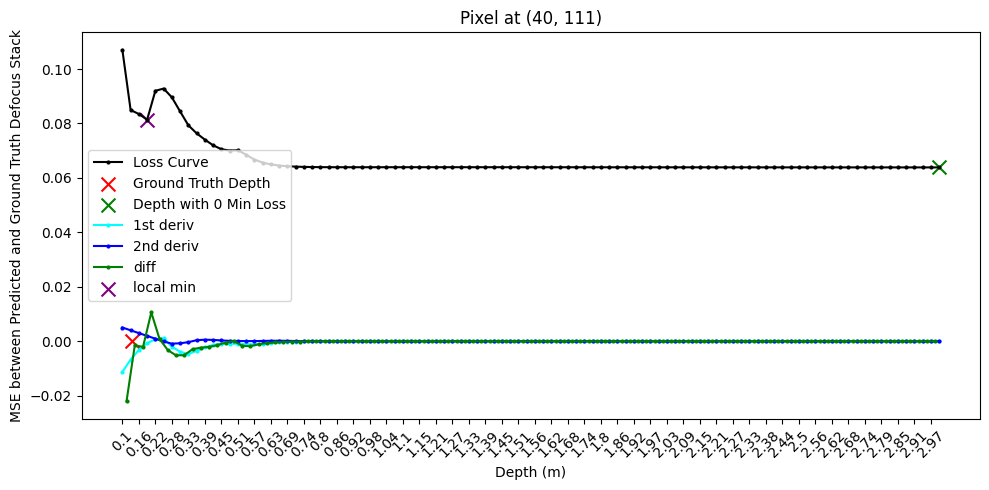

3 0.18787879 -0.2218473 -0.29669857


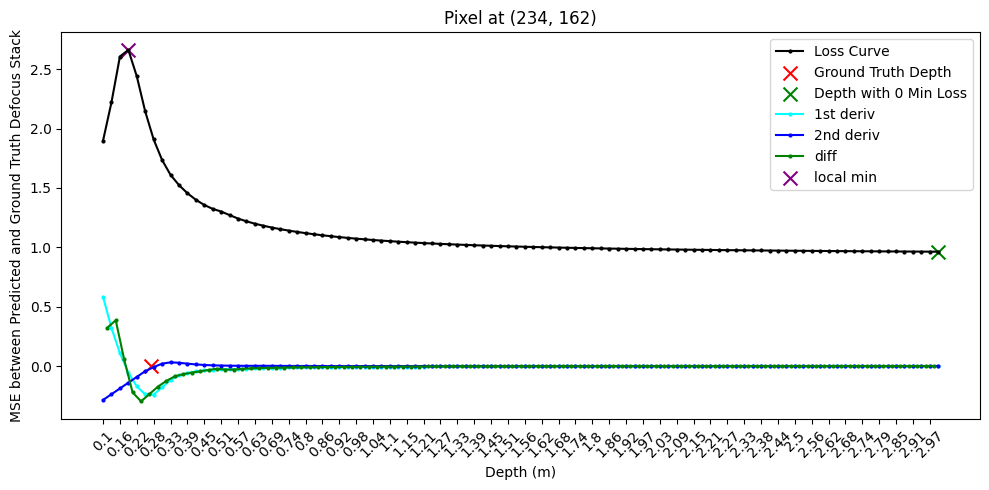

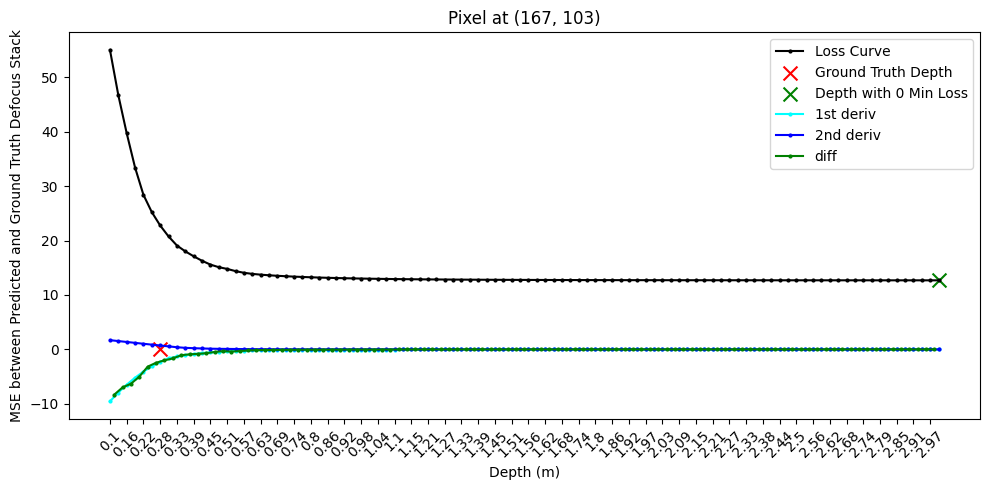

7 0.3050505 0.015071869 0.019402087
13 0.48080808 -0.0036875606 -0.008852541
22 0.74444443 0.00010573864 0.00025111437


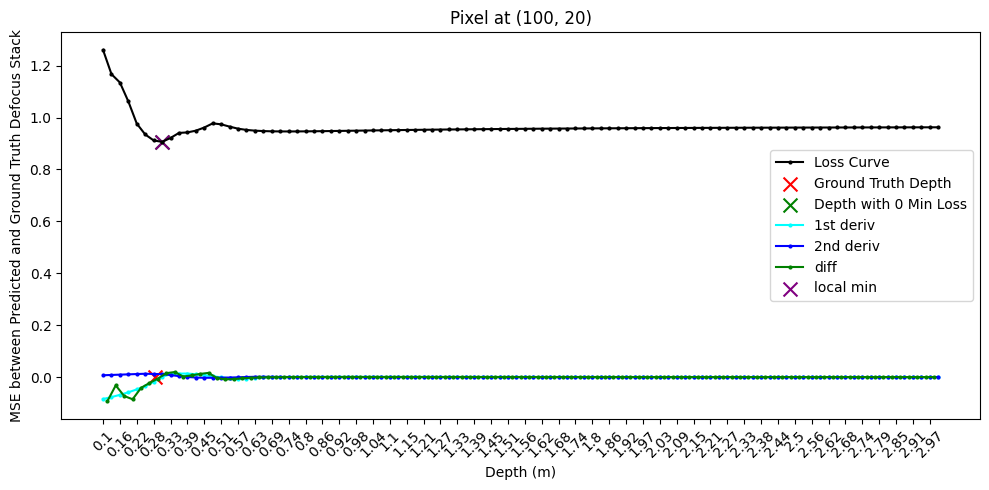

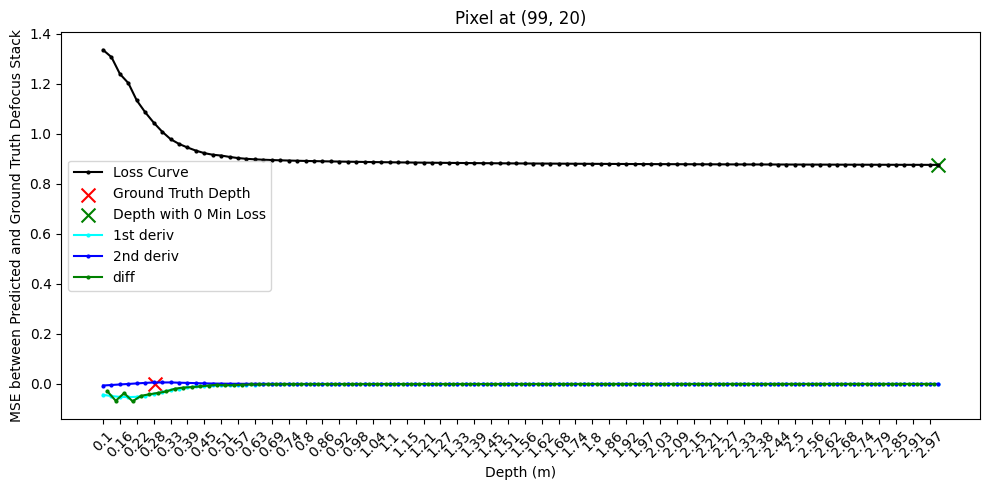

7 0.3050505 0.00029580947 0.0005007498


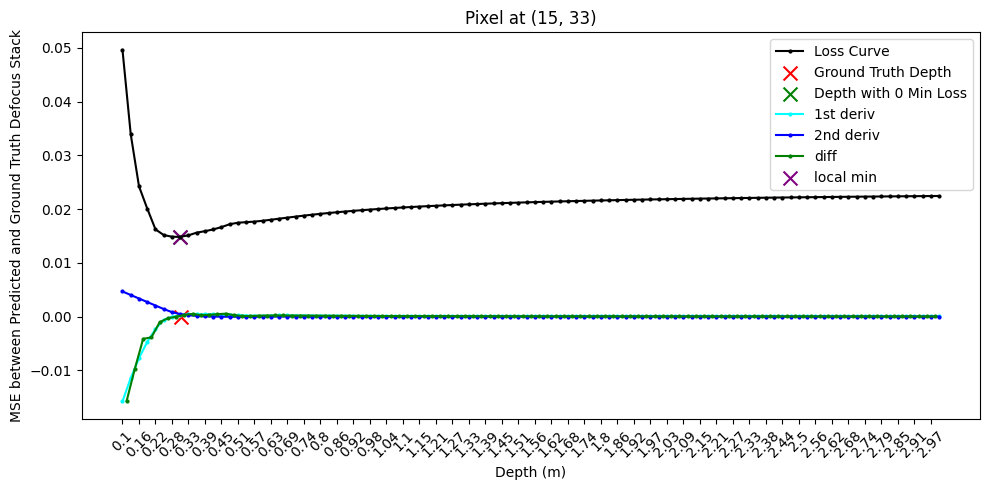

6 0.27575758 0.7311363 2.3100777


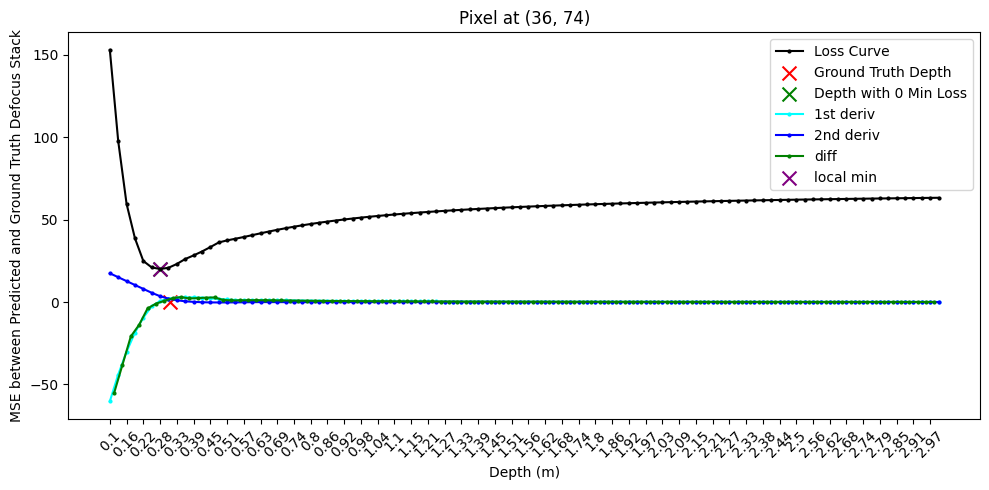

8 0.33434343 0.001449436 -9.75728e-05
9 0.36363637 -9.75728e-05 0.00025566667
10 0.3929293 0.00025566667 0.0010059029


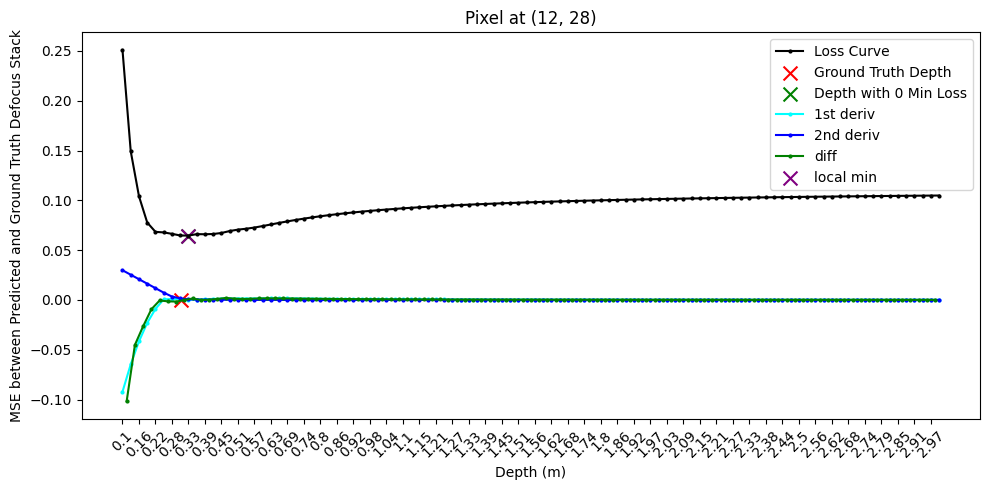

7 0.3050505 0.023959875 0.081032634


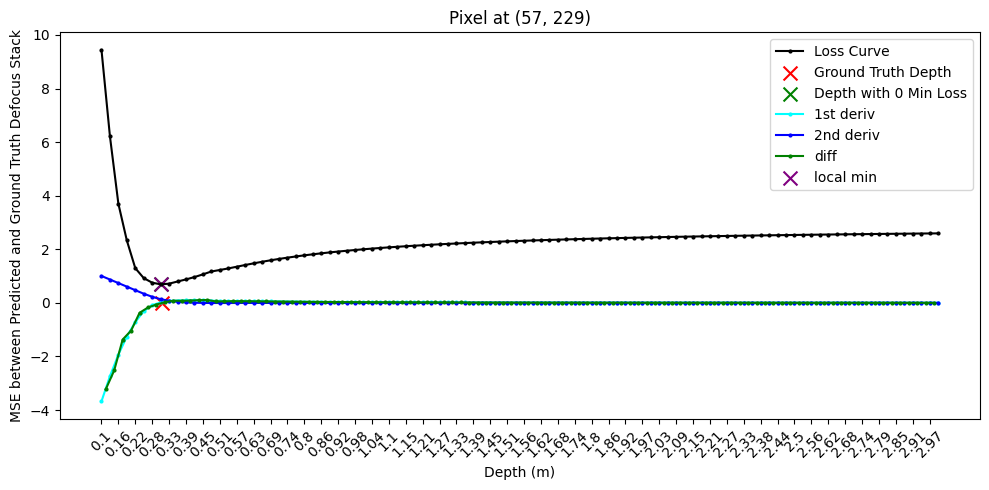

8 0.33434343 0.002189029 0.0008530766


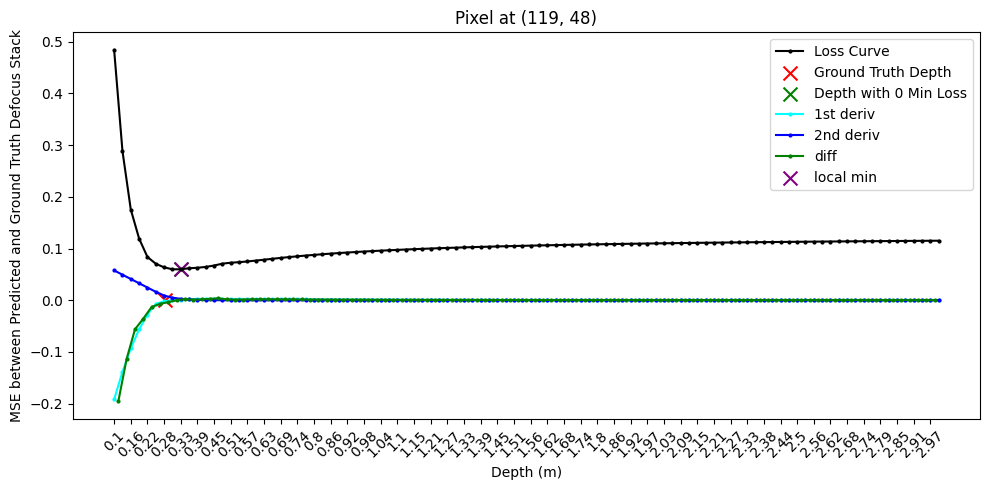

6 0.27575758 0.0006980449 0.0033626407


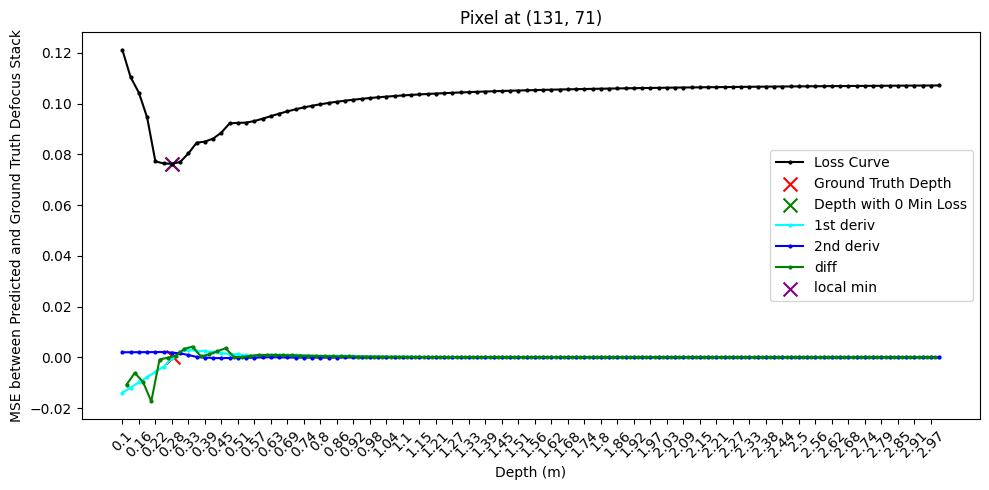

7 0.3050505 0.4302349 0.59610987


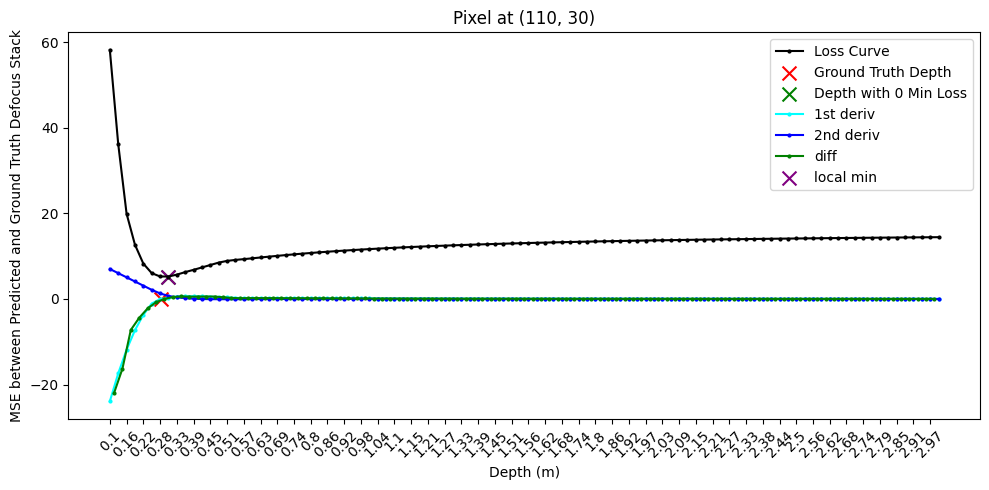

4 0.21717171 1.9113464 11.366837


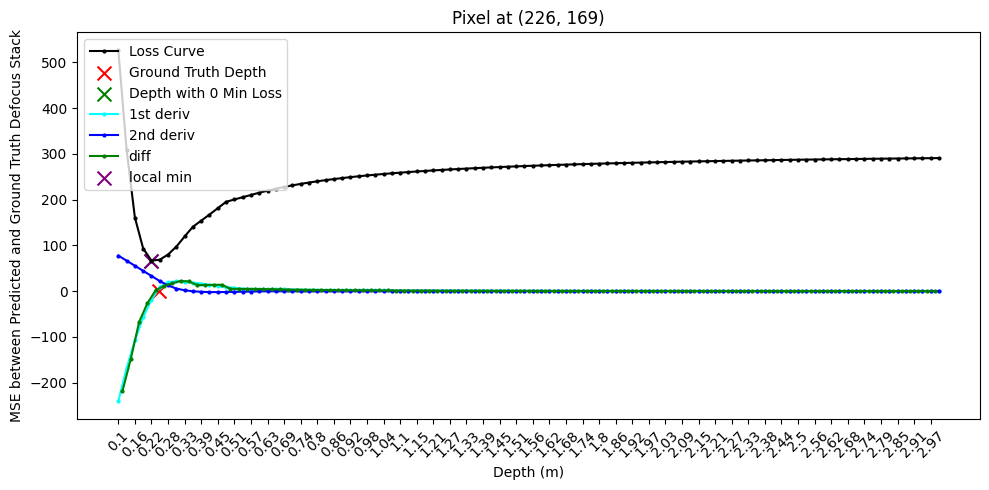

5 0.24646464 0.008052468 0.12351614


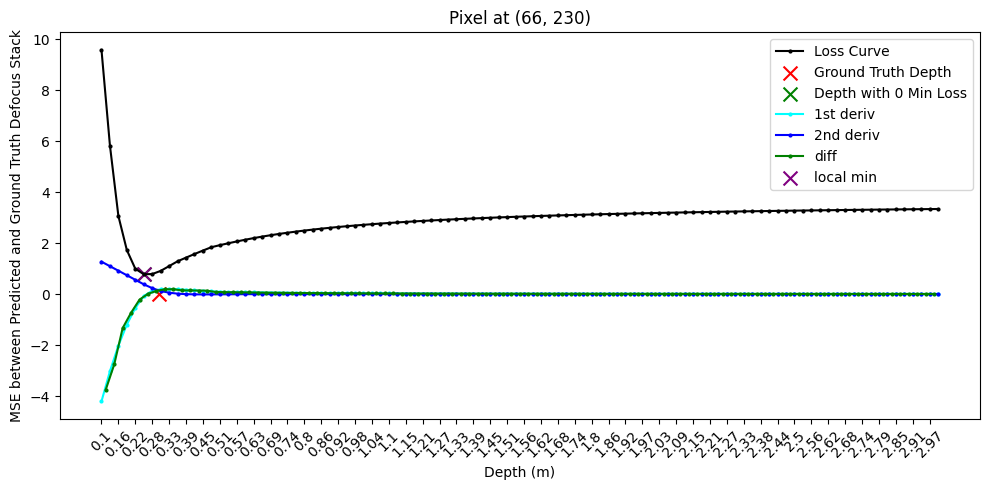

6 0.27575758 12.775711 22.474579


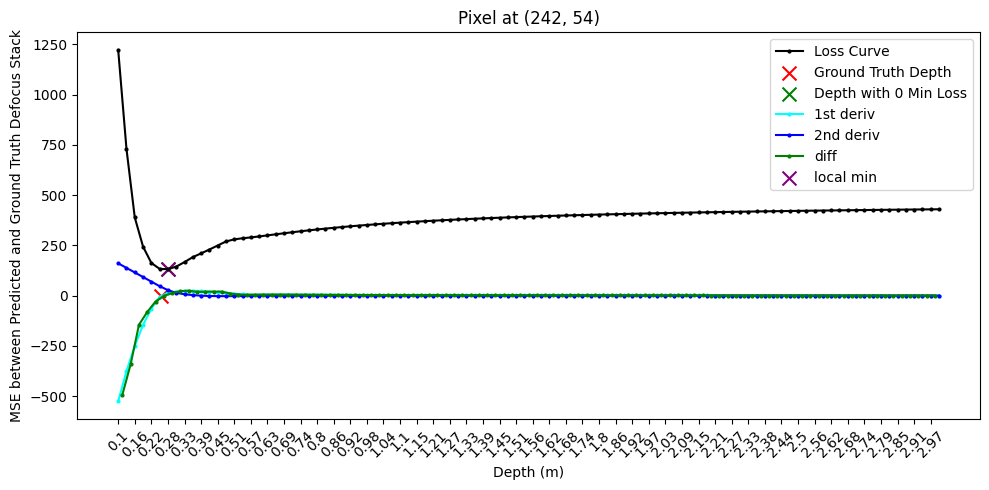

In [9]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])
    

In [ ]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])